In [191]:
import os
import sys
path = '/'.join(os.path.abspath('').split('/')[0:-2])
print(path)
sys.path.append(path)

/home/mora/Documents/projects/Bandits


In [192]:
import pandas as pd
import numpy as np
import tqdm
import pickle, json

from experts.alpha import alpha
from exploration.explore import explore
from exploration.outils import stats

In [193]:
with open('../../../datasharing/hist_stock_data.pkl','rb') as file:
    df_hst_tickers = pickle.load(file)

In [194]:
tickers = df_hst_tickers.keys()

In [195]:
df_close_stocks = pd.DataFrame()

for ticker in tickers:
    srs = df_hst_tickers[ticker][['Close']]
    srs.columns = [ticker]
    df_close_stocks = pd.concat([df_close_stocks,srs], axis = 1)
    
df_close_stocks.reset_index(inplace = True)
df_close_stocks['date'] = pd.to_datetime(df_close_stocks['Date'])

df_close_stocks.set_index('date', inplace = True)
df_2w = df_close_stocks.resample("2W").last()

/tmp/ipykernel_910249/4281973882.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_close_stocks.reset_index(inplace = True)
/tmp/ipykernel_910249/4281973882.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_close_stocks['date'] = pd.to_datetime(df_close_stocks['Date'])


## Bandit Simulation

In [196]:
with open('../../../datasharing/stock_tst_group.json', 'r') as file:
    stock_groups = json.load(file)

In [197]:
stock_groups

{'stocks_dict': ['TYL',
  'SRE',
  'VRSK',
  'MTD',
  'ILMN',
  'ROST',
  'ROL',
  'TRMB',
  'FTNT',
  'YUM',
  'WRB',
  'ATO',
  'ROK',
  'LKQ',
  'GILD',
  'SBAC',
  'ICE',
  'NKE',
  'CMG',
  'TSCO',
  'CHD',
  'BKNG',
  'DFS',
  'ANSS',
  'V',
  'HAS',
  'PSA',
  'ZTS',
  'MA',
  'ABBV',
  'MMM',
  'O',
  'PPG',
  'LYB',
  'AAPL',
  'FANG',
  'MNST',
  'ACGL',
  'NDSN',
  'NOW',
  'PNR',
  'ODFL',
  'UNP',
  'SHW',
  'TDY',
  'AWK',
  'HCA',
  'ACN',
  'FLT',
  'WMB',
  'NEE',
  'ORLY',
  'OKE',
  'AMT',
  'DLR',
  'PSX',
  'NFLX',
  'WYNN',
  'DVA',
  'IDXX',
  'WAB',
  'EXR',
  'APD',
  'CPB',
  'NCLH',
  'WST',
  'GWW',
  'GNRC',
  'AVGO',
  'CRM',
  'EVRG',
  'ROP',
  'APTV',
  'CB',
  'JKHY',
  'AMZN',
  'HUBB',
  'CAT',
  'AME',
  'CCI',
  'TDG',
  'FAST',
  'JBHT',
  'NSC',
  'FSLR',
  'CSX',
  'NXPI',
  'CHTR',
  'AON',
  'LIN',
  'AMCR',
  'TSLA',
  'RTX',
  'FRT',
  'ECL',
  'ESS',
  'CTRA',
  'TRGP',
  'WEC',
  'XEL'],
 'groups': {'0': ['TYL', 'SRE', 'VRSK', 'MTD', 'ILMN

In [198]:
def simulate_year(df_series, years: list, n_sims: int,
                  stock_groups: dict):

    df_test = df_series[df_series['Date'].dt.year.isin(years)]
    lines = []

    for group, lst_stocks in stock_groups['groups'].items():

        df_bandits = df_test[lst_stocks].pct_change(1).dropna()

        if df_bandits.shape[0] == 0:
            continue

        arguments = {"exploration_rate": 0.05,
                     "n_bandit":df_bandits.shape[1],
                     "steps":df_bandits.shape[0],
                     "alpha":0.025,
                     "df_bandits":df_bandits
                    }


        exp = explore(alpha.execute)
        exp.execute(n_sims, **arguments)
        mean, std = stats(exp.rets_compo)
        line = [arguments["alpha"],
                arguments["exploration_rate"],
                mean,
                std]

        lines.append(line)

    df_rets = pd.DataFrame(lines)
    df_rets.columns = ["alpha", "expl", "mean", "std"]
    
    return df_rets.mean()

In [207]:
stats_years = []
years = range(2013,2024)
#years = [2013,2014,2015]
for year in years:
    st_year = simulate_year(df_2w, [year], n_sims = 1)
    stats_years.append(st_year)

In [208]:
df_perf = pd.DataFrame(stats_years)
df_perf.index = years

<AxesSubplot: >

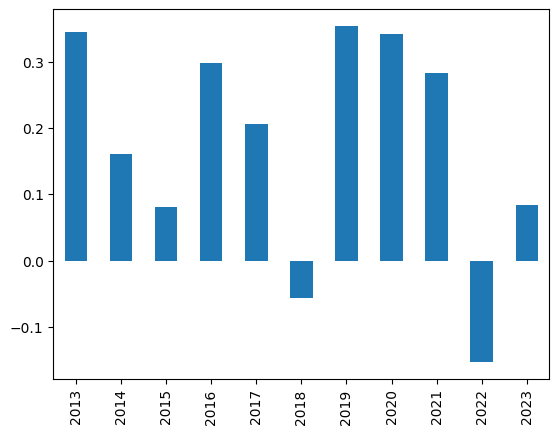

In [209]:
df_perf['mean'].plot.bar()

<AxesSubplot: >

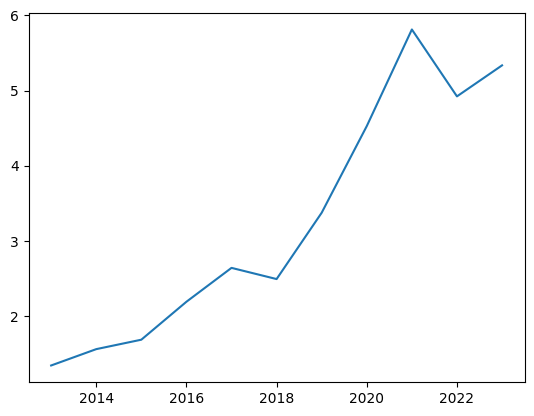

In [210]:
(df_perf['mean'] + 1).cumprod().plot()

In [211]:
(df_perf['mean'] + 1).mean()

1.1767413513587295